# Chains & Geography

In this notebook we conduct additional feature engineering to improve upon previous supervised models. We will derive the following:
- Is the business part of a chain?
- How does it compare to businesses within a 1 mile radius?

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
from collections import Counter, OrderedDict
import utils, plot_help

%matplotlib inline

In [2]:
#download data
df_bus = utils.chunk_loader('data/cleaned/business_merge_feats.csv', read_limit=-1)

df_bus.head()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,cool_change,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,33.522143,-112.018481,Arizona Biltmore Golf Club,0,...,0.000000,0.00000,0.000000,0.000000,1.777778,2012-06-16 14:53:33,2016-06-18 16:22:16,5323,3.5,0
1,30 Eglinton Avenue W,"{'RestaurantsReservations': 'True', 'GoodForMe...",QXAEGFB4oINsVuTFxEYKFQ,"Specialty Food, Restaurants, Dim Sum, Imported...",Mississauga,"{'Monday': '9:0-0:0', 'Tuesday': '9:0-0:0', 'W...",43.605499,-79.652289,Emerald Chinese Restaurant,1,...,-0.042484,-0.04902,-0.075163,-0.156863,36.083333,2010-07-05 16:56:31,2018-11-09 21:08:54,15143,3.0,1
2,"10110 Johnston Rd, Ste 15","{'GoodForKids': 'True', 'NoiseLevel': ""u'avera...",gnKjwL_1w79qoiV3IC_xQQ,"Sushi Bars, Restaurants, Japanese",Charlotte,"{'Monday': '17:30-21:30', 'Wednesday': '17:30-...",35.092564,-80.859132,Musashi Japanese Restaurant,2,...,-0.110000,-0.19000,0.055000,-0.215000,57.083333,2010-11-13 01:00:36,2018-11-10 17:15:54,58518,3.5,1
3,"15655 W Roosevelt St, Ste 237",NaN,xvX2CttrVhyG2z1dFg_0xw,"Insurance, Financial Services",Goodyear,"{'Monday': '8:0-17:0', 'Tuesday': '8:0-17:0', ...",33.455613,-112.395596,Farmers Insurance - Paul Lorenz,3,...,0.000000,0.00000,0.000000,-0.500000,1.222222,2012-10-29 22:36:50,2016-04-27 00:57:54,8464,3.5,1
4,"Credit Valley Town Plaza, F2 - 6045 Creditview Rd","{'BusinessParking': ""{'garage': False, 'street...",68dUKd8_8liJ7in4aWOSEA,"Shipping Centers, Couriers & Delivery Services...",Mississauga,"{'Monday': '9:0-19:0', 'Tuesday': '9:0-20:0', ...",43.599475,-79.711584,The UPS Store,5,...,0.000000,0.00000,0.000000,0.000000,1.000000,2014-03-31 21:46:17,2018-05-22 22:35:48,2971,3.0,1


In [3]:
#recall columns
print(*df_bus.columns, sep=', ')

address, attributes, business_id, categories, city, hours, latitude, longitude, name, postal_code, review_count, stars, state, road_type, GoodForKids, RestaurantsReservations, Caters, RestaurantsTableService, RestaurantsTakeOut, RestaurantsPriceRange2, OutdoorSeating, BikeParking, HasTV, RestaurantsGoodForGroups, RestaurantsDelivery, BusinessAcceptsCreditCards, BusinessAcceptsBitcoin, ByAppointmentOnly, AcceptsInsurance, GoodForDancing, CoatCheck, HappyHour, WheelchairAccessible, DogsAllowed, DriveThru, Corkage, BYOB, Open24Hours, RestaurantsCounterService, dessert, latenight, lunch, dinner, brunch, breakfast, garage, street, validated, lot, valet, romantic, intimate, classy, hipster, divey, touristy, trendy, upscale, casual, dj, background_music, no_music, jukebox, live, video, karaoke, monday, tuesday, friday, wednesday, thursday, sunday, saturday, straightperms, coloring, extensions, africanamerican, curly, kids, perms, asian, dairy_free, gluten_free, vegan, kosher, halal, soy_free,

# Chains

In [4]:
#get all names that are lower and duplicated
name_lower = df_bus['name'].str.lower().copy()

In [5]:
name_val_count = name_lower.value_counts(sort=True, ascending=False)

In [6]:
#see very very popular chains
name_val_count[:20]

starbucks                 1062
mcdonald's                 796
subway                     756
tim hortons                333
taco bell                  309
pizza hut                  302
walgreens                  301
burger king                301
wendy's                    292
the ups store              262
cvs pharmacy               258
circle k                   237
great clips                236
enterprise rent-a-car      206
domino's pizza             195
kfc                        186
dunkin' donuts             186
chipotle mexican grill     182
chase bank                 181
wells fargo bank           181
Name: name, dtype: int64

In [7]:
#see even less popular chains
name_val_count[(name_val_count.values==3)]

olly fresco's                       3
imperial buffet                     3
great harvest bread co              3
musicology                          3
sports deli                         3
american title service agency       3
denver mattress                     3
burrito king                        3
dino palmieri salon                 3
goodwill toronto                    3
wow sushi                           3
lola                                3
los burritos                        3
marketon                            3
family eye care                     3
penzey's spices                     3
coal miner's daughter               3
charlotte vapes                     3
kerry's car care                    3
bellair tan                         3
joe & pie cafe pizzeria             3
relaxology wellness centre          3
inchin's bamboo garden              3
sun nails                           3
guadalupe medical center            3
puck'n wings                        3
vercini     

### Let a chain be any business that has at least 5 identical entires, this will leave out common names such as dumpling house. We understand that by definition just 2 locations or more make for a chain/franchise, however we want to only account for businesses that are relatively popular.

In [8]:
#get chain names
chain_names = name_val_count[(name_val_count.values>=5)].index.tolist()
#see samples
chain_names[:10]

['starbucks',
 "mcdonald's",
 'subway',
 'tim hortons',
 'taco bell',
 'pizza hut',
 'walgreens',
 'burger king',
 "wendy's",
 'the ups store']

In [9]:
def get_chain(bus_name, chain_names=chain_names):
    #convert to string in case not a string
    bus_name_lower = str(bus_name).lower()
    #check if contained in predefied list
    if bus_name_lower in chain_names:
        return 1
    else:
        return 0
    

In [10]:
df_bus['chain'] = df_bus['name'].apply(lambda x: get_chain(x, chain_names=chain_names))

In [11]:
#get quick stats
df_bus['chain'].mean()

0.21955199801439562

In [12]:
#distribution among target value
df_bus.groupby(by='is_open', as_index=True).mean()[['chain']]

,chain
is_open,
0,0.133950
1,0.239423


# Geography

To query geodesic distances we rely on this article by `Jan Philip Matuschek`:

http://janmatuschek.de/LatitudeLongitudeBoundingCoordinates

In [13]:
#convert degrees to rad
df_bus[['longitude', 'latitude']] = df_bus[['longitude', 'latitude']].apply(np.deg2rad)
df_bus[['longitude', 'latitude']].head()

,longitude,latitude
0,-1.955091,0.585072
1,-1.390195,0.761060
2,-1.411258,0.612481
3,-1.961673,0.583911
4,-1.391230,0.760954


In [14]:
#define radius of earth in kilometers
r_earth = 6371
#We want to find places within a distance d_query in km from M=(lat, lon)
d_query = 0.5
#calculate angular radius of query circle
r_angular = d_query/r_earth
print(r_angular)

7.848061528802385e-05


In [15]:
#for illustration define longitude and latitude from first entry
lat = df_bus['latitude'][0]
long = df_bus['longitude'][0]
print(lat, long, sep='\t')

0.5850717589477232	-1.9550913112967223


In [16]:
#compute min and max latitude
lat_min = lat - r_angular
lat_max = lat + r_angular
print(lat_min, lat_max, sep='\t')

0.5849932783324352	0.5851502395630113


In [17]:
#latitude of bounding box
lat_t = np.arcsin(np.sin(lat)/np.cos(r_angular))
print(lat_t)
delta_long = np.arccos((np.cos(r_angular) - np.sin(lat_t)*np.sin(lat)) / (np.cos(lat_t)*np.cos(lat)))
print(delta_long)

0.5850717609877802
9.413842877398291e-05


In [18]:
long_min = long - delta_long
long_max = long + delta_long
print(long_min, long_max, sep='\t')

-1.9551854497254963	-1.9549971728679483


In [19]:
#sanity check query
query_circle_0 = df_bus[(df_bus['longitude']<=long_max) & (df_bus['longitude']>=long_min) 
                        & (df_bus['latitude']<=lat_max) & (df_bus['latitude']>=lat_min)]
#check cities
print(query_circle_0['city'].unique())
print(query_circle_0['state'].unique())

query_circle_0.head()

['Phoenix']
['AZ']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open,chain
0,2818 E Camino Acequia Drive,{'GoodForKids': 'False'},1SWheh84yJXfytovILXOAQ,"Golf, Active Life",Phoenix,NaN,0.585072,-1.955091,Arizona Biltmore Golf Club,0,...,0.000000,0.000000,0.000000,1.777778,2012-06-16 14:53:33,2016-06-18 16:22:16,5323,3.5,0,0
14431,2400 E Missouri Ave,"{'BusinessAcceptsCreditCards': 'False', 'Busin...",qy4OYPuUPs0g6DO2FUwksA,"Vacation Rentals, Hotels & Travel, Real Estate...",Phoenix,"{'Monday': '0:0-0:0', 'Tuesday': '0:0-0:0', 'W...",0.585082,-1.955150,Biltmore Lifestyles Real Estate,0,...,0.000000,0.000000,0.000000,1.000000,2015-05-23 19:05:58,2015-05-23 19:05:58,0,3.5,1,0
14813,2400 E Missouri Ave,"{'RestaurantsReservations': 'True', 'NoiseLeve...",wuBGY61_1-udSHUrOkM82w,"Bars, Nightlife, Lounges",Phoenix,NaN,0.585091,-1.955176,Wright Bar,0,...,0.000000,0.000000,0.000000,18.583333,2010-11-08 06:47:59,2018-11-05 03:50:17,75738,3.5,1,0
34465,2400 E Missouri Ave,"{'RestaurantsReservations': 'True', 'Restauran...",x8_NelKV1JY5S5bN7mWJuQ,"Restaurants, Local Flavor, Breakfast & Brunch,...",Phoenix,"{'Monday': '6:0-21:30', 'Tuesday': '6:0-21:30'...",0.585091,-1.955176,Frank & Albert's,0,...,-0.119919,-0.054201,-0.306233,57.083333,2010-01-30 18:34:54,2018-11-09 01:03:55,23341,3.5,1,0
51097,2400 E Missouri Ave,"{'RestaurantsPriceRange2': '3', 'WiFi': ""'free...",Rk94R2M9CwIaYcQ02ow1AA,"Resorts, Hotels & Travel, Hotels, Event Planni...",Phoenix,NaN,0.585091,-1.955176,Arizona Biltmore Resort & Spa Catering,0,...,-0.111111,-0.888889,0.111111,9.333333,2013-08-26 07:34:37,2018-07-28 19:38:51,43454,3.5,1,0


In [20]:
def bounding_box(lat, long, d_query=1.0, r_sphere=6371.):
    """Compute the bounding box around latitude and longitude on a sphere
    lat(float) = latitude
    long(float) = longitude
    d_query(float) = Distance d_query in km from M=(lat, lon)
    r_sphere(float) = radius of sphere
    """
    #calculate angular radius of query circle
    r_angular = d_query/r_sphere
    
    #compute min and max latitude
    lat_min = lat - r_angular
    lat_max = lat + r_angular
    
    #latitude of bounding box
    lat_t = np.arcsin(np.sin(lat)/np.cos(r_angular))
    
    #define change in longitude
    delta_long = np.arccos((np.cos(r_angular) - np.sin(lat_t)*np.sin(lat)) / (np.cos(lat_t)*np.cos(lat)))
    
    #min and max longitude
    long_min = long - delta_long
    long_max = long + delta_long
    
    return lat_min, lat_max, long_min, long_max


In [21]:
def query_df_spatial(df, row, d_query=2.0, r_sphere=6371., long_col='longitude', lat_col='latitude'):
    """
    Returns a copy of a dataframe bounded by latitude and longitude at specific row
    df(pandas) = pandas dataframe MUST contain columns for longitude and latitude
    row(int): row idx
    d_query(float) = Distance d_query in km from M=(lat, lon)
    r_sphere(float) = radius of sphere
    long_col(str) = column for longitude
    lat_col(str) = column for latitude
    
    """
    
    lat, long = df[lat_col][row], df['longitude'][row]
    
    #get boundaries
    lat_min, lat_max, long_min, long_max = bounding_box(lat, long, d_query=d_query, r_sphere=r_sphere)
    #query
    df_query = df[(df[long_col]<=long_max) & 
                  (df[long_col]>=long_min) & 
                  (df[lat_col]<=lat_max) & 
                  (df[lat_col]>=lat_min)].copy()
        
    return df_query
    

In [22]:
#sanity check
print (df_bus.iloc[5,:5])
query_circle_5 = query_df_spatial(df_bus, 5)

#check cities
print(100*'-')
print(query_circle_5['city'].unique())
print(query_circle_5['state'].unique())

query_circle_5.head()

address                         20 Douglas Woods Drive Southeast
attributes     {'RestaurantsPriceRange2': '2', 'BusinessParki...
business_id                               5JucpCfHZltJh5r1JabjDg
categories                            Beauty & Spas, Hair Salons
city                                                     Calgary
Name: 5, dtype: object
----------------------------------------------------------------------------------------------------
['Calgary']
['AB']


,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,funny_change,stars_change,useful,avg_month_checkin,first,last,span_checkin,median_income,is_open,chain
5,20 Douglas Woods Drive Southeast,"{'RestaurantsPriceRange2': '2', 'BusinessParki...",5JucpCfHZltJh5r1JabjDg,"Beauty & Spas, Hair Salons",Calgary,NaN,0.889134,-1.989707,Edgeworxx Studio,6,...,0.000000,0.083333,-0.166667,1.000000,2013-11-06 01:04:53,2013-11-06 01:04:53,0,4.0,1,0
8572,3250 114 Avenue SE,NaN,PS1lg9D3MBkzRUZMHUYyCg,"Auto Detailing, Automotive, Car Wash",Calgary,"{'Monday': '5:0-23:0', 'Tuesday': '5:0-23:0', ...",0.889245,-1.989528,Harper's Tire Car Wash,1316,...,-0.733333,-0.400000,-0.533333,2.090909,2012-02-17 18:14:47,2017-02-19 04:50:40,38153,4.0,1,0
31808,"11566 24 Street SE, Suite 315","{'RestaurantsReservations': 'True', 'Restauran...",rJY01VBs43ZbqUKq4mY1rA,"Restaurants, Vietnamese",Calgary,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",0.889262,-1.989719,Saigon Annam,6851,...,0.000000,0.125000,-0.250000,3.200000,2011-04-02 01:01:53,2015-09-24 18:58:51,64618,4.0,0,0
41160,428 - 11520 24 Street SE,"{'ByAppointmentOnly': 'False', 'RestaurantsPri...",jKQDFs2ml-0AMg4LGlo3PA,"Waxing, Beauty & Spas, Nail Salons, Eyelash Se...",Calgary,"{'Monday': '10:0-19:0', 'Tuesday': '10:0-19:0'...",0.889283,-1.989679,Jeena Nails & Spa,188,...,0.000000,0.000000,-1.333333,1.000000,2018-05-02 00:37:26,2018-05-02 00:37:26,0,4.0,1,0
46568,"Douglas Square Shopping Center Mall, 11566 24 ...","{'OutdoorSeating': 'False', 'RestaurantsGoodFo...",llF6C8YmWYf_lalHnz7D1A,"Restaurants, Vietnamese",Calgary,"{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'...",0.889261,-1.989712,Spring Vietnamese Cuisine,6851,...,0.000000,0.333333,0.083333,1.900000,2016-01-29 01:57:58,2018-07-09 17:16:58,55140,4.0,1,0


### Note that intestingly enough the first couple entries of the dataframe are located in the same exact address and appear to belong to a complex

In [34]:
query_circle_80 = query_df_spatial(df_bus, 80)
query_circle_80.head()

,address,attributes,business_id,categories,city,hours,latitude,longitude,name,postal_code,...,first,last,span_checkin,median_income,chain,density,review_density,stars_density,price_density,is_open
80,3105 Highway 7,"{'RestaurantsPriceRange2': '2', 'BusinessParki...",HBQG_DT8pfbkv8jiv3P6Gw,"Shopping, Discount Store",Markham,"{'Monday': '9:30-21:0', 'Tuesday': '9:30-21:0'...",0.765292,-1.384984,Winners,80,...,2012-06-16 18:41:39,2018-07-22 18:23:17,85298,3.0,1,401,-0.436522,-0.926081,0.616943,1
549,71 Cochrane Drive,"{'BikeParking': 'True', 'BusinessParking': ""{'...",OkXjIwGUEGcyofyjPITZ8A,"Gyms, Active Life, Fitness & Instruction",Markham,"{'Monday': '0:0-12:0', 'Tuesday': '0:0-12:0', ...",0.765290,-1.385091,Fit4less,382,...,2016-11-23 23:05:09,2018-08-29 16:58:40,64411,3.0,1,466,-0.529507,-0.287398,-1.680442,1
1744,8425 Woodbine Avenue,"{'GoodForMeal': ""{'dessert': False, 'latenight...",6sATfFam9_q9uod0I2aCsg,"Chinese, Restaurants, Vegetarian",Markham,"{'Monday': '10:30-21:30', 'Tuesday': '10:30-21...",0.765292,-1.385038,Wu Tai Vegetarian Restaurant,877,...,2013-05-08 23:54:19,2018-11-04 19:26:49,70350,3.0,0,415,1.373977,0.272658,0.606335,1
1821,3255 Highway 7 E,NaN,ojXlVfeYKBisI6EJ0UizAA,"Restaurants, Fast Food, Chinese",Markham,NaN,0.765323,-1.384872,Canton Chang Fen,902,...,2018-09-09 17:44:13,2018-11-13 01:31:04,28011,3.0,0,374,-0.329194,0.242669,-1.494034,1
2311,"3235 Highway 7 E, Unit 29","{'RestaurantsGoodForGroups': 'True', 'Restaura...",3fw2X5bZYeW9xCz_zGhOHg,"Food, Chinese, Restaurants, Desserts",Markham,"{'Monday': '14:0-0:0', 'Tuesday': '14:0-0:0', ...",0.765308,-1.384880,Tracy Dessert,902,...,2010-07-02 01:33:52,2018-11-04 01:20:29,85597,3.0,0,374,1.481694,0.250308,-0.413890,1


In [23]:
def normalize(x, df, feature):
    
    val = df[feature][x]
    #get series
    series = df[feature]
    #get mean
    mean = series.mean()
    #get standard dev
    standev = (series.std())
    #avoid mathematical error
    if standev==0:
        standev=1
    
    #standardize
    standard = (val - mean)/standev
    
    #provision for nan
    if pd.isna(standard):
        return 0
    else:
        return standard

In [24]:
#instantiate arrays
density = []
review_count = [] 
stars = []
price_range = []

for i in df_bus.index:
    #get df filtered by location
    df_space = query_df_spatial(df_bus, i, d_query=2.0)
    
    #get density from nearby businesses
    count = df_space.shape[0]
    density.append(count)
    
    #populate arrays with comparisions
    review = normalize(i, df_space, 'review_count')
    review_count.append(review)
    
    star = normalize(i, df_space, 'stars')
    stars.append(star)
    
    price = normalize(i, df_space, 'RestaurantsPriceRange2')
    price_range.append(price)
    

In [25]:
#add new columns
df_bus['density'] = density
df_bus['review_density'] = review_count
df_bus['stars_density'] = stars
df_bus['price_density'] = price_range


#get list of columns
cols = list(df_bus.columns.values)
#remove is_open from list
cols.pop(cols.index('is_open'))
#move is_open to last position
df_bus= df_bus[cols + ['is_open']]

In [26]:
#save the work
df_bus.to_csv('data/cleaned/business_merge_density_added.csv')

In [27]:
#recall columns
print(*df_bus.columns, sep=', ')

address, attributes, business_id, categories, city, hours, latitude, longitude, name, postal_code, review_count, stars, state, road_type, GoodForKids, RestaurantsReservations, Caters, RestaurantsTableService, RestaurantsTakeOut, RestaurantsPriceRange2, OutdoorSeating, BikeParking, HasTV, RestaurantsGoodForGroups, RestaurantsDelivery, BusinessAcceptsCreditCards, BusinessAcceptsBitcoin, ByAppointmentOnly, AcceptsInsurance, GoodForDancing, CoatCheck, HappyHour, WheelchairAccessible, DogsAllowed, DriveThru, Corkage, BYOB, Open24Hours, RestaurantsCounterService, dessert, latenight, lunch, dinner, brunch, breakfast, garage, street, validated, lot, valet, romantic, intimate, classy, hipster, divey, touristy, trendy, upscale, casual, dj, background_music, no_music, jukebox, live, video, karaoke, monday, tuesday, friday, wednesday, thursday, sunday, saturday, straightperms, coloring, extensions, africanamerican, curly, kids, perms, asian, dairy_free, gluten_free, vegan, kosher, halal, soy_free,

## Evaluate New Features

In [28]:
df_bus[['density', 'review_density',  'stars_density', 'price_density']].describe()

,density,review_density,stars_density,price_density
count,161160.000000,161160.000000,161160.000000,161160.000000
mean,835.646463,-0.010347,0.002192,-0.008001
std,1175.205418,0.970848,0.994205,0.992882
min,1.000000,-1.870311,-4.176961,-2.295170
25%,177.000000,-0.437689,-0.671975,-0.952760
50%,418.000000,-0.314645,0.103366,0.020534
75%,914.000000,-0.012520,0.755229,0.761905
max,6979.000000,28.408934,2.464135,4.614381


Text(0, 0.5, 'Count')

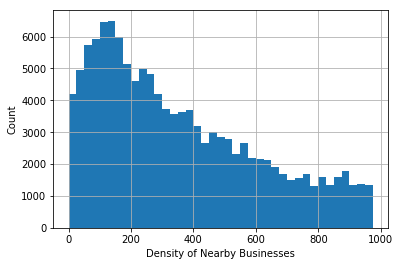

In [29]:
df_bus['density'].hist(bins=np.arange(0,1000,25))
plt.xlabel("Density of Nearby Businesses")
plt.ylabel("Count")

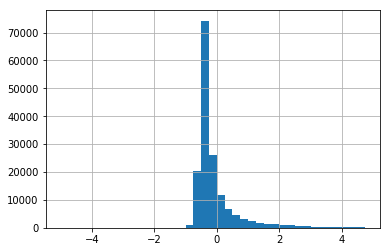

In [30]:
df_bus['review_density'].hist(bins=np.arange(-5,5,0.25))

Text(0, 0.5, 'Count')

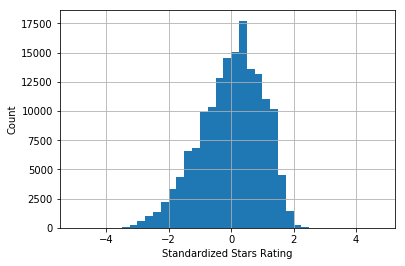

In [31]:
df_bus['stars_density'].hist(bins=np.arange(-5,5,0.25))
plt.xlabel("Standardized Stars Rating")
plt.ylabel("Count")

Text(0, 0.5, 'Count')

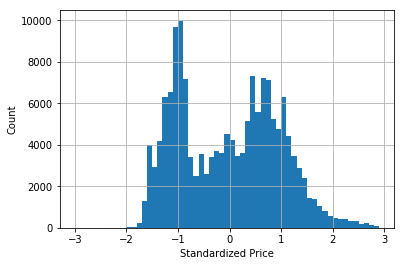

In [32]:
df_bus['price_density'].hist(bins=np.arange(-3,3,0.1))
plt.xlabel("Standardized Price")
plt.ylabel("Count")